In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
IMG_HEIGHT, IMG_WIDTH = 256, 256  
BATCH_SIZE = 32                     
EPOCHS = 50                       

In [4]:
import os
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
            images.append(img)
    return np.array(images)


pre_disaster_images = load_images_from_folder('dataset/train/pre_disaster/')
post_disaster_images = load_images_from_folder('dataset/train/post_disaster/')

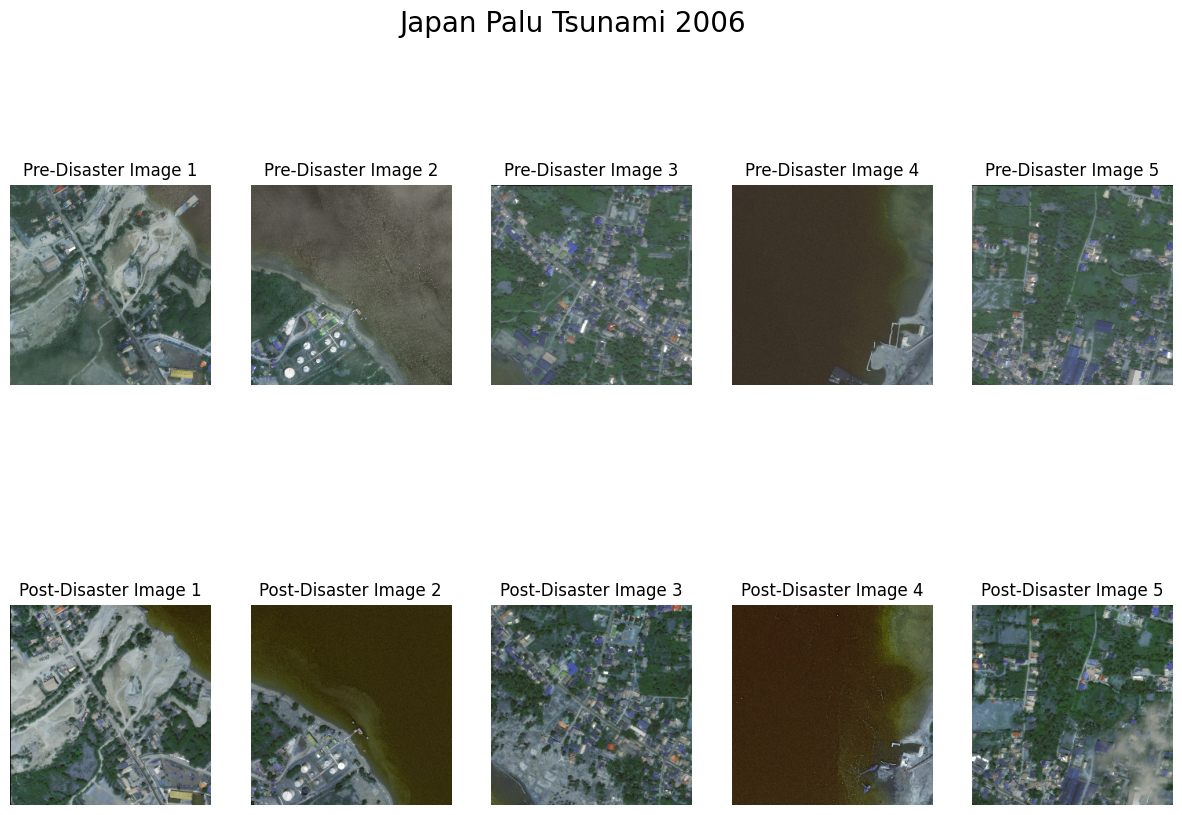

In [5]:
def show_first_five_images(pre_disaster, post_disaster):
    plt.figure(figsize=(15, 10))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.title(f'Pre-Disaster Image {i+1}')
        plt.imshow(pre_disaster[i])
        plt.axis('off')

        plt.subplot(2, 5, i+6)
        plt.title(f'Post-Disaster Image {i+1}')
        plt.imshow(post_disaster[i])
        plt.axis('off')
    
    plt.suptitle("Japan Palu Tsunami 2006", fontsize=20)
    plt.show()

show_first_five_images(pre_disaster_images, post_disaster_images)

In [6]:
pre_disaster_images = pre_disaster_images / 255.0
post_disaster_images = post_disaster_images / 255.0

In [7]:
y_train_binary = np.where(post_disaster_images.sum(axis=-1, keepdims=True) > 0, 1, 0)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(pre_disaster_images, y_train_binary, test_size=0.2, random_state=42)

In [9]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [10]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = layers.Input(input_size)
    
    
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder path
    u6 = layers.Conv2DTranspose(256,(2 ,2) ,strides=(2 ,2) ,padding='same')(c5) 
    u6=layers.concatenate([u6 ,c4]) 
    c6=layers.Conv2D(256 ,(3 ,3) ,activation='relu' ,padding='same')(u6)

    u7=layers.Conv2DTranspose(128,(2 ,2) ,strides=(2 ,2) ,padding='same')(c6) 
    u7=layers.concatenate([u7 ,c3]) 
    c7=layers.Conv2D(128 ,(3 ,3) ,activation='relu' ,padding='same')(u7)

    u8=layers.Conv2DTranspose(64,(2 ,2) ,strides=(2 ,2) ,padding='same')(c7) 
    u8=layers.concatenate([u8 ,c2]) 
    c8=layers.Conv2D(64,(3 ,3) ,activation='relu' ,padding='same')(u8)

    u9=layers.Conv2DTranspose(32,(2 ,2) ,strides=(2 ,2) ,padding='same')(c8) 
    u9=layers.concatenate([u9 ,c1]) 
    c9=layers.Conv2D(32,(3 ,3) ,activation='relu' ,padding='same')(u9)
 
    outputs=layers.Conv2D(1,(1 ,1) ,activation='sigmoid')(c9)

    model=models.Model(inputs=[inputs] ,outputs=[outputs]) 
    return model 

In [11]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
history=model.fit(datagen.flow(X_train,y_train,batch_size=BATCH_SIZE),
                  validation_data=(X_val,y_val),
                  epochs=10,
                  steps_per_epoch=len(X_train)//BATCH_SIZE,
                  validation_steps=len(X_val)//BATCH_SIZE)

model.save('disaster_damage_assessment_model.h5')

Epoch 1/10


C:\Users\Inbavel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 105s 32s/step - accuracy: 0.9419 - loss: 0.6435 - val_accuracy: 0.9466 - val_loss: 0.3882
Epoch 2/10
1/3 ━━━━━━━━━━━━━━━━━━━━ 1:05 33s/step - accuracy: 0.9487 - loss: 0.4012

C:\Users\Inbavel\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9487 - loss: 0.4012 - val_accuracy: 0.9466 - val_loss: 0.0917
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 26s/step - accuracy: 0.9064 - loss: 0.2399 - val_accuracy: 0.9466 - val_loss: 0.1330
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.9745 - loss: 0.1140 - val_accuracy: 0.9466 - val_loss: 0.1199
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 29s/step - accuracy: 0.9273 - loss: 0.1747 - val_accuracy: 0.9466 - val_loss: 0.0703
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9396 - loss: 0.1345 - val_accuracy: 0.9466 - val_loss: 0.0657
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 91s 31s/step - accuracy: 0.9034 - loss: 0.2087 - val_accuracy: 0.9466 - val_loss: 0.0672
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.9497 - loss: 0.1051 - val_accuracy: 0.9466 - val_loss: 0.0707
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 89s 32s/step - accuracy: 0.9139 - loss: 0.1663 - val_accuracy: 0.9466 - val_loss: 0.0831
Epoch 10/10
3/3

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 32)      │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 32)      │           9,248 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 32)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 64)      │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 64)      │          36,928 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 64)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 128)       │          73,856 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 128)       │         147,584 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 128)       │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 256)       │         295,168 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 32, 32, 256)       │         590,080 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 16, 16, 256)       │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 16, 16, 512)       │       1,180,160 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 16, 16, 512)       │       2,359,808 │ conv2d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose              │ (None, 32, 32, 256)       │         524,54

 Total params: 20,928,773 (79.84 MB)

 Trainable params: 6,976,257 (26.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,952,516 (53.22 MB)

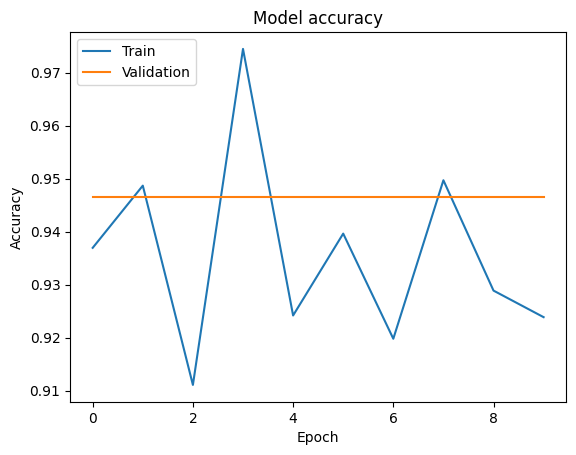

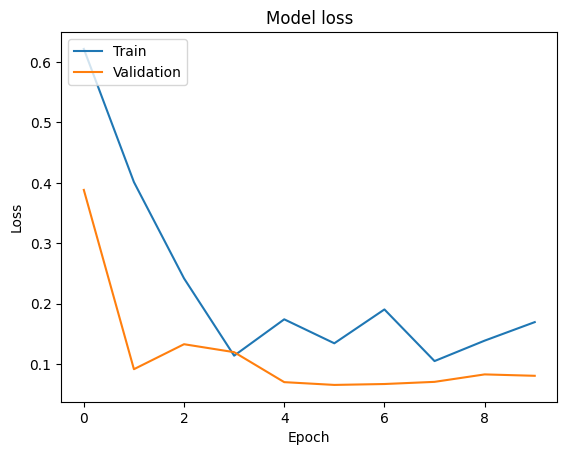

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
y_pred=model.predict(X_val) 
y_pred_binary=(y_pred>0.5).astype(np.uint8) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [25]:
def calculate_damage_percentage(prediction):
   damage_area=np.sum(prediction) 
   total_area=prediction.size 
   damage_percentage=(damage_area/total_area)*100 
   return damage_percentage 

In [26]:
def calculate_cost(damage_percentage): 
   cost_per_acre=50000 
   total_area_acres=X_val.shape[1]*X_val.shape[0]/4046.86 
   
   damage_area_acres=total_area_acres*(damage_percentage/100) 

   cost_estimate=damage_area_acres*cost_per_acre  
   return cost_estimate 


In [27]:
def classify_damage(damage_percentage): 
   if damage_percentage >50: 
       return "High Damage" 
   elif damage_percentage >20: 
       return "Medium Damage" 
   else: 
       return "Low Damage" 

Damage Percentage: 97.09%
Damage Classification: High Damage
Estimated Cost of Damage: $95202.66m


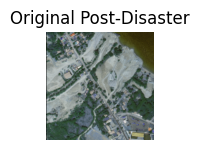

In [28]:
sample_index=0 
plt.subplot(1 ,4 ,2)  
plt.title('Original Post-Disaster')  
plt.imshow(post_disaster_images[sample_index])  
plt.axis('off') 
damage_percentage=calculate_damage_percentage(y_pred[sample_index]) 
damage_classification=classify_damage(damage_percentage) 
cost=calculate_cost(damage_percentage) 

print(f"Damage Percentage: {damage_percentage:.2f}%") 
print(f"Damage Classification: {damage_classification}") 
print(f"Estimated Cost of Damage: ${cost:.2f}m") 


In [29]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")

Final Training Accuracy: 92.39%
Final Validation Accuracy: 94.66%


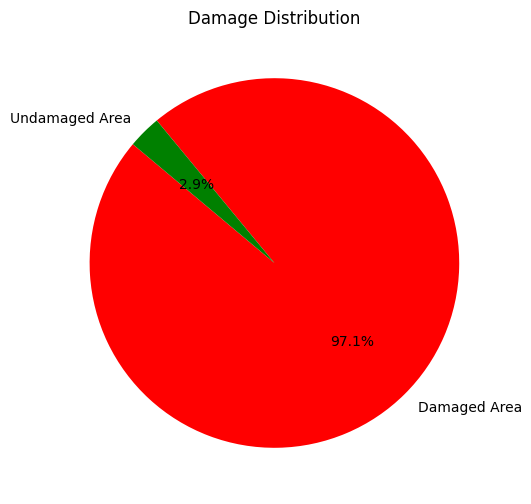

In [38]:
def pie_chart_damage_analysis(damage_percentage):
    labels = ['Damaged Area', 'Undamaged Area']
    sizes = [damage_percentage, 100 - damage_percentage]
    colors = ['red', 'green']
    
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title('Damage Distribution')
    plt.show()
pie_chart_damage_analysis(damage_percentage)

In [31]:
def display_results_without_boxes(pre_disaster_image, original_image, prediction):
    plt.figure(figsize=(6, 16)) 

    plt.subplot(4, 1, 1)
    plt.title('Pre-Disaster Image', fontsize=12)
    plt.imshow(pre_disaster_image)
    plt.axis('off')

    plt.subplot(4, 1, 2)
    plt.title('Original Post-Disaster', fontsize=12)
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(4, 1, 3 )
    plt.title('Predicted Damage Mask (Normal Colormap)', fontsize=12)
    
    plt.imshow(prediction.squeeze(), cmap='viridis')
    plt.colorbar(label='Damage Levels')  
    plt.axis('off')
    plt.subplot(4, 1, 4 )

    color_values = [0, 1, 2, 3]
    color_meanings = ['No Damage', 'Low Damage', 'Medium Damage', 'High Damage']
    plt.barh(color_meanings, color_values, color=['white', 'yellow', 'orange', 'red'])
    plt.xlabel('Damage Levels')
    plt.grid(False)
    plt.axis('off')
    plt.subplot(4, 1,4 )
    plt.title('Highlightes Damage', fontsize=12)
    
    plt.imshow(prediction.squeeze(), cmap='hot')
    plt.axis('off')
    
   

    
    


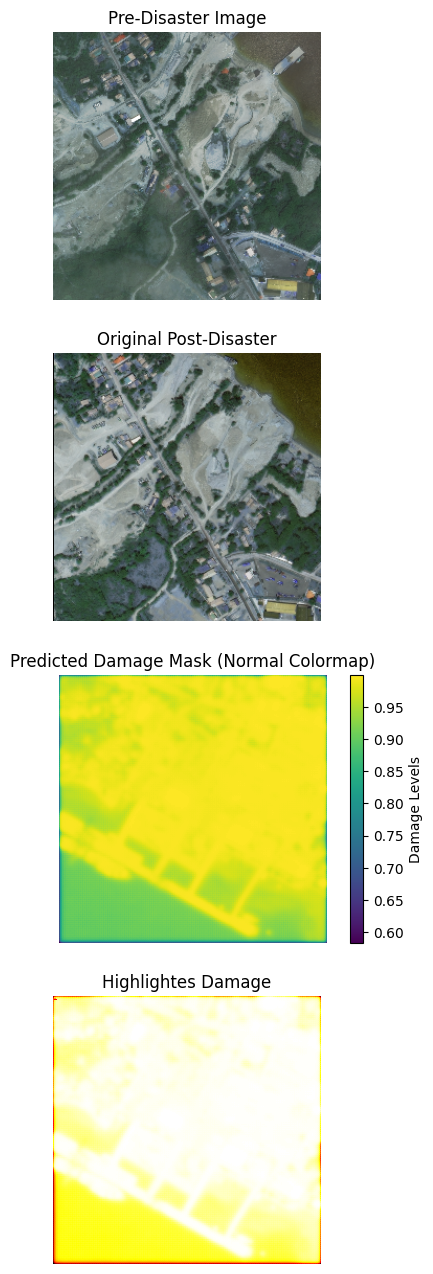

In [32]:
display_results_without_boxes(pre_disaster_images[sample_index], post_disaster_images[sample_index], y_pred[sample_index])


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def apply_custom_colormap(prediction):
    
    normalized_prediction = (prediction - prediction.min()) / (prediction.max() - prediction.min())

    colored_mask = np.zeros((*normalized_prediction.shape, 3), dtype=np.uint8)

    colored_mask[normalized_prediction <= 0.2] = [255, 255, 255]  
    colored_mask[(normalized_prediction > 0.2) & (normalized_prediction <= 0.5)] = [255, 255, 0]  
    colored_mask[(normalized_prediction > 0.5) & (normalized_prediction <= 0.8)] = [255, 165, 0]  
    colored_mask[normalized_prediction > 0.8] = [255, 0, 0]  

    return colored_mask


def display_damage_levels_and_mask(prediction):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  

    axs[0].set_title('Predicted Damage Mask (Pixel-Level Colors)', fontsize=12)
    colored_mask = apply_custom_colormap(prediction.squeeze())
    axs[0].imshow(colored_mask)
    axs[0].axis('off')
    
    im = axs[0].imshow(colored_mask, cmap='jet')  
    fig.colorbar(im, ax=axs[0], label='Damage Levels')

    axs[1].set_title('Damage Levels Explained', fontsize=12)
    color_values = [0, 1, 2, 3]
    color_meanings = ['No Damage', 'Low Damage', 'Medium Damage', 'High Damage']
    axs[1].barh(color_meanings, color_values, color=['white', 'yellow', 'orange', 'red'])
    axs[1].set_xlabel('Damage Levels')
    axs[1].grid(False)
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()



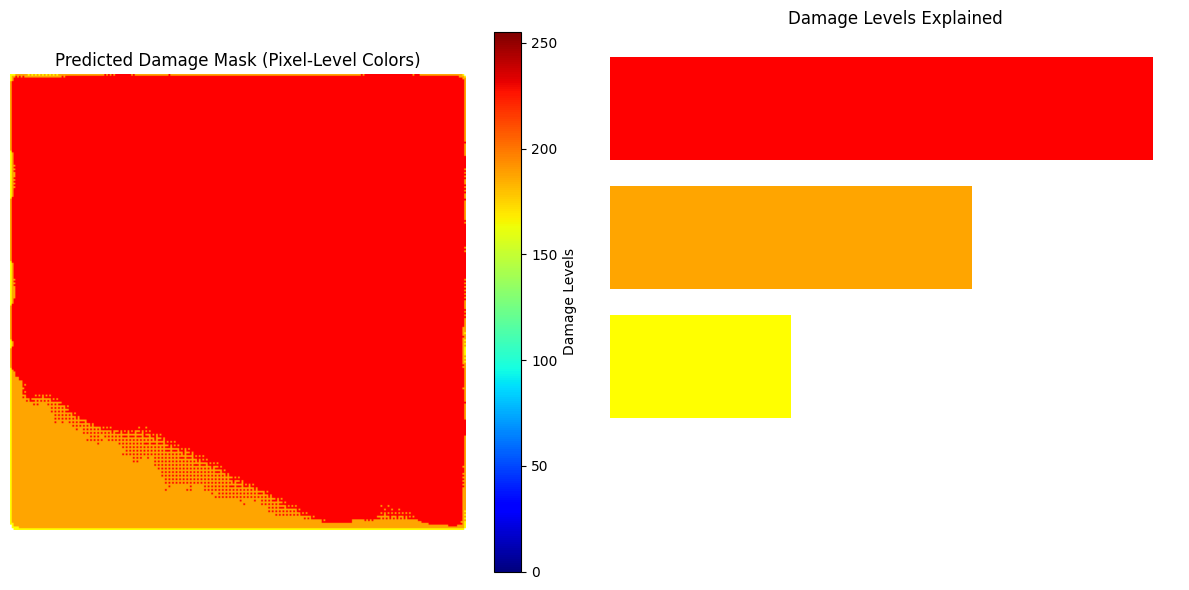

In [34]:
display_damage_levels_and_mask(y_pred[0])